In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
gpytorch.functions.fast_pred_var = True

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)])
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/30 - Loss: 1.149
Iter 2/30 - Loss: 1.092
Iter 3/30 - Loss: 1.041
Iter 4/30 - Loss: 1.000
Iter 5/30 - Loss: 0.971
Iter 6/30 - Loss: 0.942
Iter 7/30 - Loss: 0.935
Iter 8/30 - Loss: 0.920
Iter 9/30 - Loss: 0.905
Iter 10/30 - Loss: 0.872
Iter 11/30 - Loss: 0.825
Iter 12/30 - Loss: 0.764
Iter 13/30 - Loss: 0.688
Iter 14/30 - Loss: 0.568
Iter 15/30 - Loss: 0.450
Iter 16/30 - Loss: 0.327
Iter 17/30 - Loss: 0.210
Iter 18/30 - Loss: 0.104
Iter 19/30 - Loss: 0.018
Iter 20/30 - Loss: -0.053
Iter 21/30 - Loss: -0.109
Iter 22/30 - Loss: -0.146
Iter 23/30 - Loss: -0.151
Iter 24/30 - Loss: -0.139
Iter 25/30 - Loss: -0.125
Iter 26/30 - Loss: -0.112
Iter 27/30 - Loss: -0.108
Iter 28/30 - Loss: -0.122
Iter 29/30 - Loss: -0.142
Iter 30/30 - Loss: -0.153
CPU times: user 1.34 s, sys: 120 ms, total: 1.46 s
Wall time: 1.46 s


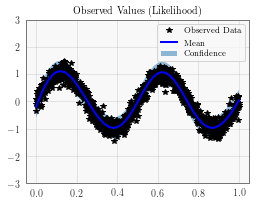

In [5]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')